In [9]:
import numpy as np
import torch
import torch.autograd as autograd
import matplotlib.pyplot as plt

In [10]:
sample_size = 10000
sample_dim = 10
noise_scale = 1.0
train_split = 0.8
theta_range = 10
data_range = 100
epoch = 50000
lr = 1e-5

In [11]:
def get_data(sample_size, sample_dim, noise_scale, train_split):
    theta = np.random.uniform(-theta_range, theta_range, sample_dim)
    X = np.random.uniform(-data_range, data_range, (sample_size, sample_dim))
    y = np.dot(X, theta) + noise_scale * np.random.normal(0, 1, sample_size)
    train_size = int(sample_size * train_split)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    #print("Actual theta: ", theta)
    return X_train, y_train, X_test, y_test

In [12]:
class Model(torch.nn.Module):
    def __init__(self, sample_dim, lr, X_train, y_train):
        super().__init__()
        self.theta = torch.nn.Parameter(torch.randn(sample_dim, 1))
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        self.loss_fn = torch.nn.MSELoss()
        self.X_train, self.y_train = X_train, y_train

    def forward(self, X):
        return torch.matmul(X, self.theta).squeeze()
    
    def train(self, X, y, epoch, lr):
        for _ in range(epoch):
            self.optimizer.zero_grad()
            loss = self.loss_fn(self(X), y)
            loss.backward()
            self.optimizer.step()
    
    def test(self, X, y):
        return self.loss_fn(self(X), y)
    
    def get_loss_with_theta(self, theta):
        return self.loss_fn(torch.matmul(self.X_train, theta).squeeze(), self.y_train)
    
    def get_hessian(self, X, y):
        return autograd.functional.hessian(self.get_loss_with_theta, self.theta.squeeze())

log_ratio: 0, sample_size: 10, sample_dim: 10
Sum of all entries: 373195.71875
Sum of diagonal entries: 64533.31640625
Ratio: 0.1729208379983902

log_ratio: 0.5, sample_size: 31, sample_dim: 10
Sum of all entries: 319616.8125
Sum of diagonal entries: 75034.3984375
Ratio: 0.23476362228393555

log_ratio: 1, sample_size: 100, sample_dim: 10
Sum of all entries: 179443.28125
Sum of diagonal entries: 68968.0546875
Ratio: 0.38434457778930664

log_ratio: 1.5, sample_size: 316, sample_dim: 10
Sum of all entries: 122154.59375
Sum of diagonal entries: 63312.52734375
Ratio: 0.5182983875274658

log_ratio: 2, sample_size: 1000, sample_dim: 10
Sum of all entries: 101216.21875
Sum of diagonal entries: 66329.0078125
Ratio: 0.6553199291229248

log_ratio: 2.5, sample_size: 3162, sample_dim: 10
Sum of all entries: 84543.203125
Sum of diagonal entries: 68134.53125
Ratio: 0.8059137463569641

log_ratio: 3, sample_size: 10000, sample_dim: 10
Sum of all entries: 78129.5
Sum of diagonal entries: 66819.34375
Rat

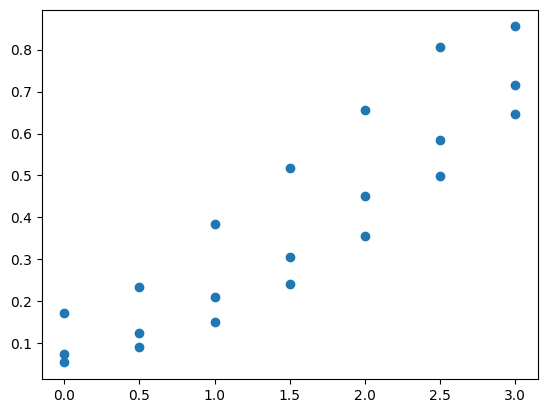

In [13]:
log_ratio_set = [0, 0.5, 1, 1.5, 2, 2.5, 3]
dim_set = [10, 50, 100]
size_ratio = []
hessian_ratio = []
for sample_dim in dim_set:
    for log_ratio in log_ratio_set:
        sample_size = int(sample_dim * 10**log_ratio)
        X_train, y_train, X_test, y_test = get_data(sample_size, sample_dim, noise_scale, train_split)
        X_train, y_train, X_test, y_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
        model = Model(sample_dim, lr, X_test, y_test)
        model.train(X_train, y_train, epoch, lr)
        print(f"log_ratio: {log_ratio}, sample_size: {sample_size}, sample_dim: {sample_dim}")
        #print(f"Estimated theta: {model.theta.data.T}")
        hessian = model.get_hessian(X_test, y_test)
        #print(f"Hessian: {hessian}")
        all_entries = hessian.abs().sum()
        diagonal_entries = torch.diag(hessian).abs().sum()
        print(f"Sum of all entries: {all_entries}")
        print(f"Sum of diagonal entries: {diagonal_entries}")
        print(f"Ratio: {diagonal_entries / all_entries}")
        print()
        size_ratio.append(log_ratio)
        hessian_ratio.append(diagonal_entries / all_entries)

plt.plot(size_ratio, hessian_ratio, 'o')
plt.show()

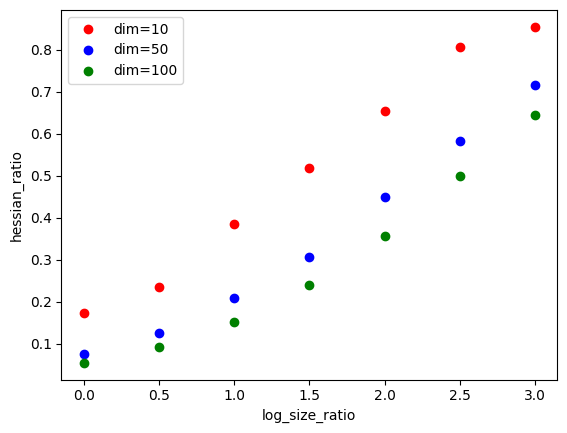

In [14]:
plt.plot(size_ratio[:7], hessian_ratio[:7], 'ro')
plt.plot(size_ratio[7:14], hessian_ratio[7:14], 'bo')
plt.plot(size_ratio[14:], hessian_ratio[14:], 'go')
plt.xlabel("log_size_ratio")
plt.ylabel("hessian_ratio")
plt.legend(["dim=10", "dim=50", "dim=100"])
plt.savefig("./arts/hessian_ratio.png")
plt.show()